# Stroke Prediction Symptom Checker
This notebook guides you through the process of creating a simple symptom checker for stroke prediction using a RandomForestClassifier. We will load and preprocess the data, train a model, and then use this model to predict the likelihood of a stroke based on input symptoms.


## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

## Load and Explore the Data
We start by loading the data and taking a preliminary look at its structure and contents.

In [2]:
stroke_data = pd.read_excel('StrokeData.xlsx')
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## About the Dataset

### Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [3]:
count_row = stroke_data.shape[0]  # Gives number of rows
count_col = stroke_data.shape[1]  # Gives number of columns
print("Number of rows: ", count_row)
print("Number of columns: ", count_col)

Number of rows:  5110
Number of columns:  12


### Checking for null values

In [4]:
stroke_data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Data Preprocessing

Before we can train our model, we need to preprocess our data. This includes handling missing values, encoding categorical variables, and possibly feature scaling. 


### Dropping NaN Values 

In [5]:
stroke_data_dropped = stroke_data.dropna()

### Checking if NaN values were dropped

In [6]:
stroke_data_dropped.isnull().sum()
dropped_rows = stroke_data_dropped.shape[0]
number_dropped_rows = count_row - dropped_rows
print("Number of rows after dropped data: ", dropped_rows)
print("Number of dropping rows: ", number_dropped_rows)

Number of rows after dropped data:  4909
Number of dropping rows:  201


### Another method is to add mean value

In [7]:
# Imputing missing values in 'bmi' based on the average BMI per gender
stroke_data['bmi'] = stroke_data.groupby('gender')['bmi'].transform(lambda x: x.fillna(x.mean()))

# Verifying the imputation
stroke_data[stroke_data['bmi'].isnull()].head(), stroke_data.head()

(Empty DataFrame
 Columns: [id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
 Index: [],
       id  gender   age  hypertension  heart_disease ever_married  \
 0   9046    Male  67.0             0              1          Yes   
 1  51676  Female  61.0             0              0          Yes   
 2  31112    Male  80.0             0              1          Yes   
 3  60182  Female  49.0             0              0          Yes   
 4   1665  Female  79.0             1              0          Yes   
 
        work_type Residence_type  avg_glucose_level        bmi  \
 0        Private          Urban             228.69  36.600000   
 1  Self-employed          Rural             202.21  29.065758   
 2        Private          Rural             105.92  32.500000   
 3        Private          Urban             171.23  34.400000   
 4  Self-employed          Rural             174.12  24.000000   
 
     smokin

### Checking if BMI is filled

In [8]:
stroke_data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Categorical variables encoding

#### Storing categorical columns

In [9]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [10]:
# Encoding categorical variables using Label Encoding
label_encoder = LabelEncoder()
for column in categorical_columns:
    stroke_data[column] = label_encoder.fit_transform(stroke_data[column])

# Display the updated DataFrame after imputation and encoding
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,29.065758,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


## Data Exploration
Here we explore the dataset to understand its distribution, characteristics, and the relationships between different features.

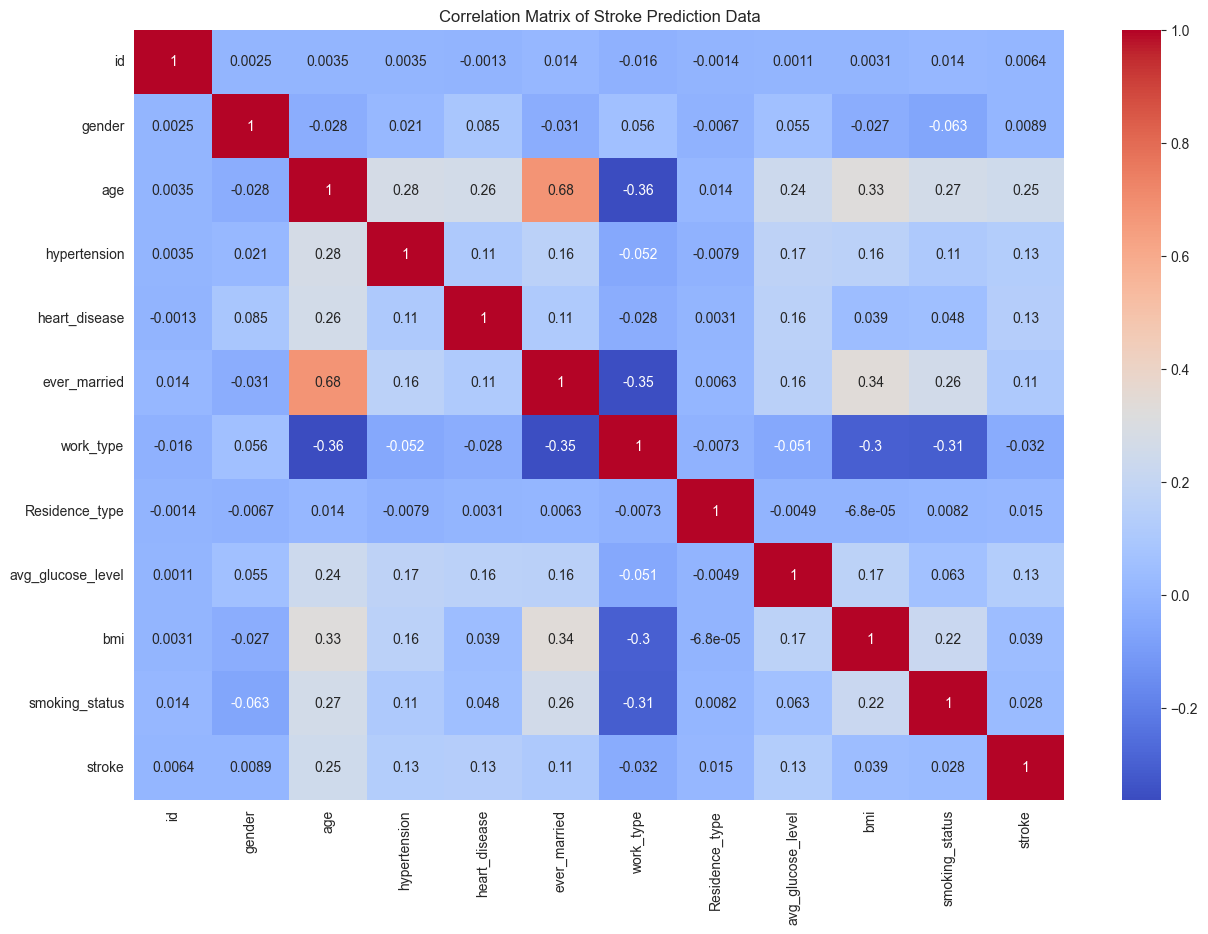

In [11]:
# Setting up the visualization
plt.figure(figsize=(15, 10))
# Correlation matrix heatmap
corr_matrix = stroke_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.title('Correlation Matrix of Stroke Prediction Data')
plt.show()

In [12]:
# Preparing the data for feature selection
X = stroke_data.drop(['stroke', 'id'], axis=1)  # Dropping 'id' as it's not a relevant feature
y = stroke_data['stroke']

# Applying SelectKBest to extract top features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)

# Creating a DataFrame to visualize feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': fit.scores_
}).sort_values(by="Score", ascending=False)

feature_scores



,Feature,Score
1,age,3635.226911
7,avg_glucose_level,1718.285446
3,heart_disease,87.987436
2,hypertension,75.449498
4,ever_married,20.622787
8,bmi,15.836315
9,smoking_status,3.369423
5,work_type,2.925901
6,Residence_type,0.600717
0,gender,0.239001


## Model Building
In this section, we build and train a machine learning model for stroke prediction using the selected features.


In [13]:
# Using all features except 'id'
X = stroke_data.drop(['id', 'stroke'], axis=1)
y = stroke_data['stroke']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Building the models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(probability=True, random_state=42)
nb_model = GaussianNB()

In [15]:
# Training the models
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)

GaussianNB()

In [16]:
# Predicting and evaluating each model
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions, zero_division=0)

svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions, zero_division=0)

nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_report = classification_report(y_test, nb_predictions, zero_division=0)

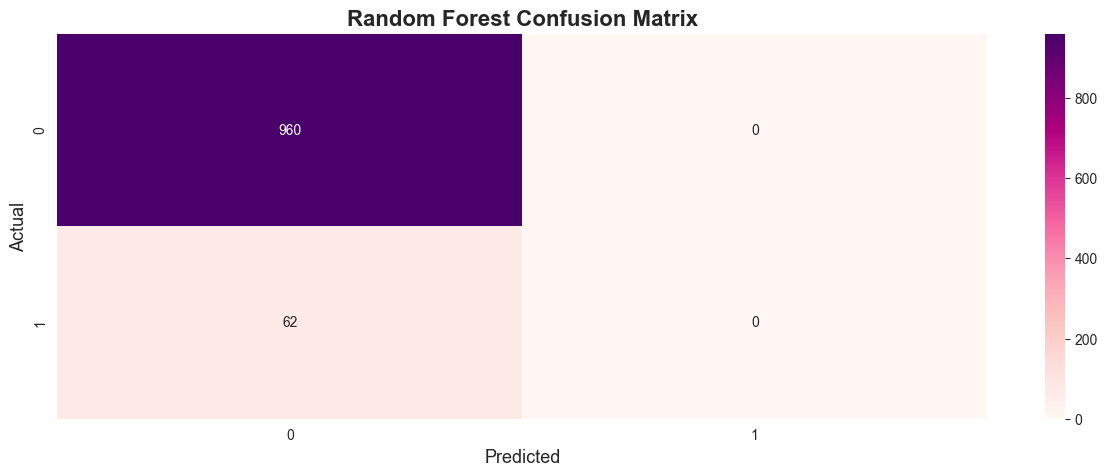

In [17]:
# Confusion matrix for the Random Forest model
plt.figure(figsize=(15,5))
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap="RdPu")
plt.title("Random Forest Confusion Matrix", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.show()

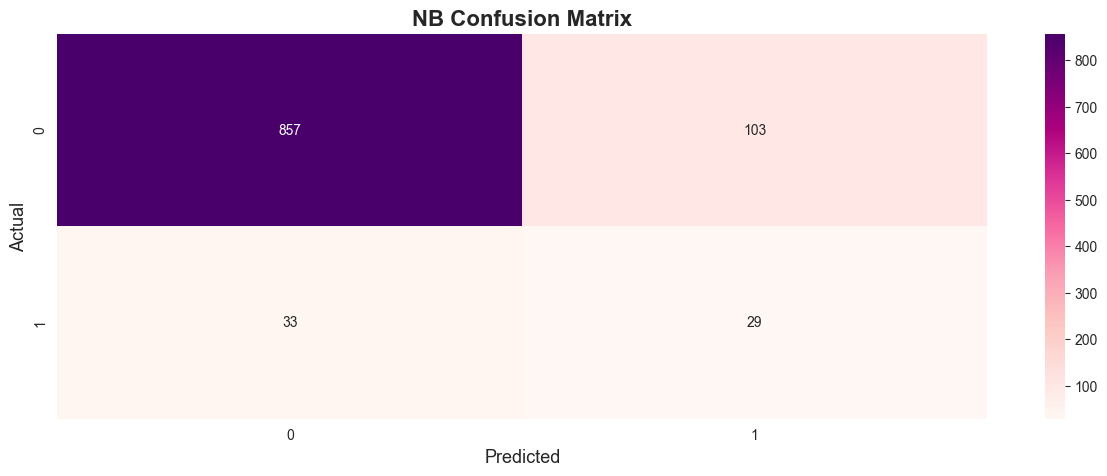

In [18]:
# Confusion matrix for the NB model
plt.figure(figsize=(15,5))
rf_conf_matrix = confusion_matrix(y_test, nb_predictions)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap="RdPu")
plt.title("NB Confusion Matrix", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.show()

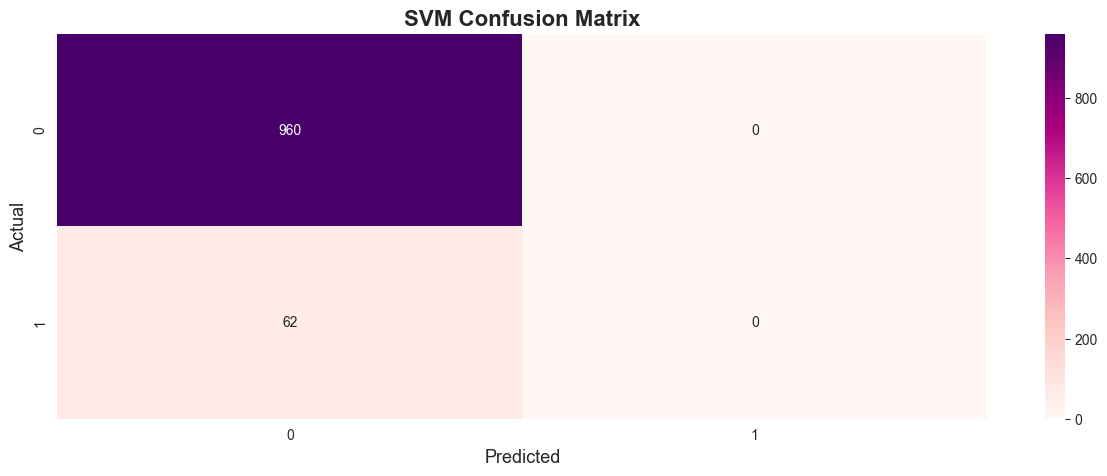

In [19]:
# Confusion matrix for the SVM model
plt.figure(figsize=(15,5))
rf_conf_matrix = confusion_matrix(y_test, svm_predictions)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap="RdPu")
plt.title("SVM Confusion Matrix", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.show()

## Applying Smote

In [20]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [21]:
# Re-train models on the balanced dataset
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model_smote = SVC(probability=True, random_state=42)
nb_model_smote = GaussianNB()

In [22]:
rf_model_smote.fit(X_train_smote, y_train_smote)
svm_model_smote.fit(X_train_smote, y_train_smote)
nb_model_smote.fit(X_train_smote, y_train_smote)

GaussianNB()

In [23]:
# Predict and evaluate each model
rf_predictions_smote = rf_model_smote.predict(X_test)
svm_predictions_smote = svm_model_smote.predict(X_test)
nb_predictions_smote = nb_model_smote.predict(X_test)

In [24]:
rf_accuracy_smote = accuracy_score(y_test, rf_predictions_smote)
svm_accuracy_smote = accuracy_score(y_test, svm_predictions_smote)
nb_accuracy_smote = accuracy_score(y_test, nb_predictions_smote)

In [25]:
rf_report_smote  = classification_report(y_test, rf_predictions_smote, zero_division=0)
svm_report_smote  = classification_report(y_test, svm_predictions_smote, zero_division=0)
nb_report_smote  = classification_report(y_test, nb_predictions_smote, zero_division=0)

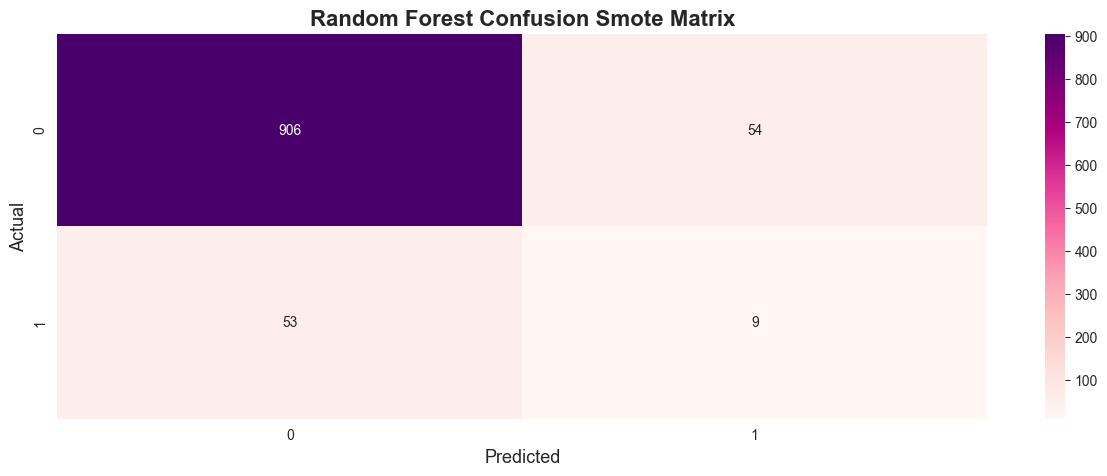

In [26]:
# Confusion matrix for the Random Forest model
plt.figure(figsize=(15, 5))
rf_conf_matrix = confusion_matrix(y_test, rf_predictions_smote)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap="RdPu")
plt.title("Random Forest Confusion Smote Matrix", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.show()


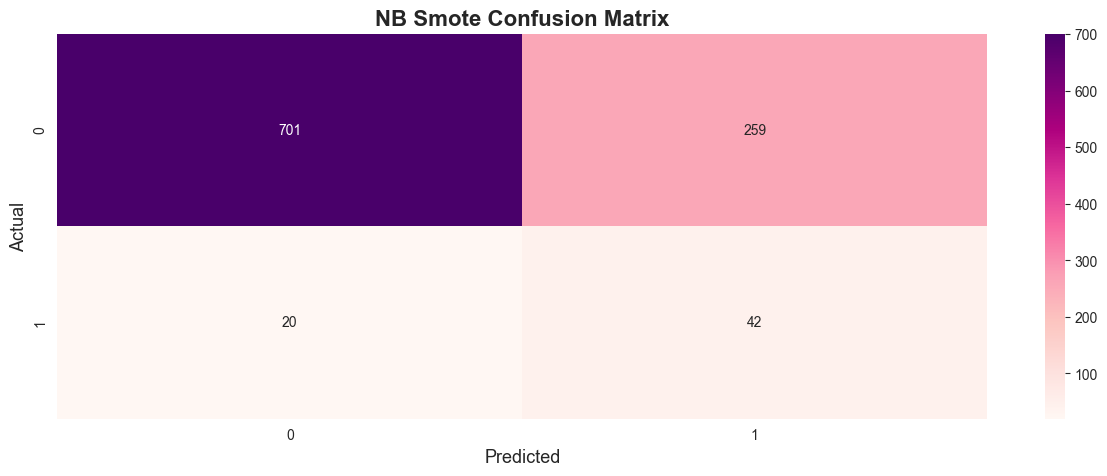

In [27]:
# Confusion matrix for the NB model
plt.figure(figsize=(15, 5))
rf_conf_matrix = confusion_matrix(y_test, nb_predictions_smote)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap="RdPu")
plt.title("NB Smote Confusion Matrix", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.show()

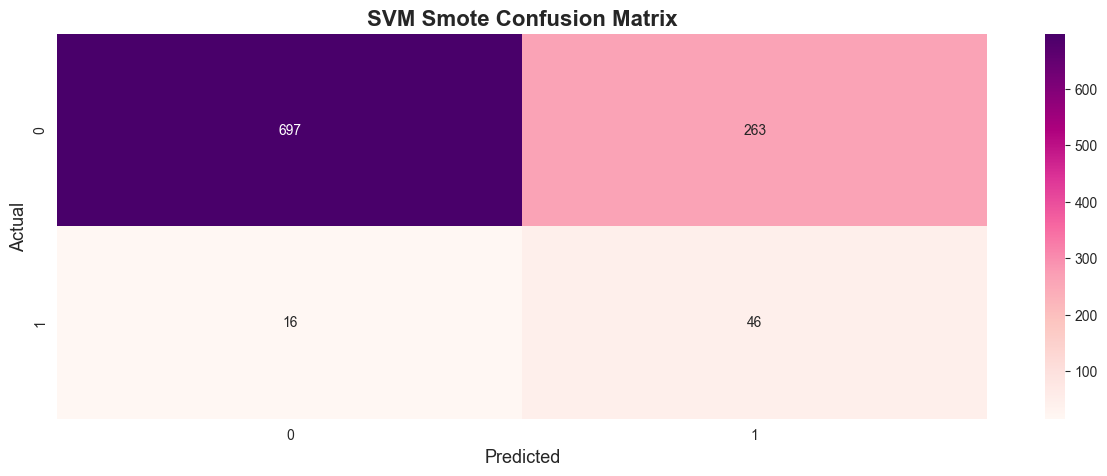

In [28]:

# Confusion matrix for the SVM model
plt.figure(figsize=(15, 5))
rf_conf_matrix = confusion_matrix(y_test, svm_predictions_smote)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap="RdPu")
plt.title("SVM Smote Confusion Matrix", fontsize=16, weight="bold")
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.show()

In [29]:
# Print the results
print("Random Forest Model Accuracy:", rf_accuracy_smote)
print(rf_report_smote)
print("SVM Model Accuracy:", svm_accuracy_smote)
print(svm_report_smote)
print("Naive Bayes Model Accuracy:", nb_accuracy_smote)
print(nb_report_smote)

Random Forest Model Accuracy: 0.8953033268101761
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       960
           1       0.14      0.15      0.14        62

    accuracy                           0.90      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.90      0.90      0.90      1022

SVM Model Accuracy: 0.7270058708414873
              precision    recall  f1-score   support

           0       0.98      0.73      0.83       960
           1       0.15      0.74      0.25        62

    accuracy                           0.73      1022
   macro avg       0.56      0.73      0.54      1022
weighted avg       0.93      0.73      0.80      1022

Naive Bayes Model Accuracy: 0.7270058708414873
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       960
           1       0.14      0.68      0.23        62

    accuracy                           0.73    

In [30]:
# Prediction function for all three models
def predict_stroke_risk(userinput):
    # Convert user input into DataFrame
    user_input_df = pd.DataFrame([userinput])

    # Use the trained models to predict the stroke likelihood
    rf_proba = rf_model.predict_proba(user_input_df)[0][1]
    svm_proba = svm_model.predict_proba(user_input_df)[0][1]
    nb_proba = nb_model.predict_proba(user_input_df)[0][1]

    return {
        "Random Forest Stroke Risk (%)": round(rf_proba * 100, 2),
        "SVM Stroke Risk (%)": round(svm_proba * 100, 2),
        "Naive Bayes Stroke Risk (%)": round(nb_proba * 100, 2)
    }



In [31]:
# Prediction function for all three models
def predict_stroke_risk_smote(userinput):
    # Convert user input into DataFrame
    user_input_df = pd.DataFrame([userinput])

    # Use the trained models to predict the stroke likelihood
    rf_proba = rf_model_smote.predict_proba(user_input_df)[0][1]
    svm_proba = svm_model_smote.predict_proba(user_input_df)[0][1]
    nb_proba = nb_model_smote.predict_proba(user_input_df)[0][1]

    return {
        "Random Forest Stroke Risk (%)": round(rf_proba * 100, 2),
        "SVM Stroke Risk (%)": round(svm_proba * 100, 2),
        "Naive Bayes Stroke Risk (%)": round(nb_proba * 100, 2)
    }



In [32]:
# Hypothetical user input based on the proposed questionnaire structure
user_input = {
    "gender": 1,  # Assuming male is encoded as 1
    "age": 30,
    "hypertension": 0,
    "heart_disease": 1,
    "ever_married": 1,  # Assuming 'Yes' is encoded as 1
    "work_type": 2,  # Assuming specific encoding for work types
    "Residence_type": 1,  # Assuming 'Urban' is encoded as 1
    "avg_glucose_level": 150,
    "bmi": 28,
    "smoking_status": 1  # Assuming specific encoding for smoking status
}

predicted_risks = predict_stroke_risk(user_input)
predicted_risks_smote = predict_stroke_risk_smote(user_input)

print("Predicted Stroke Risks:", predicted_risks)
print("Predicted Stroke Risks:", predicted_risks_smote)

Predicted Stroke Risks: {'Random Forest Stroke Risk (%)': 3.0, 'SVM Stroke Risk (%)': 4.68, 'Naive Bayes Stroke Risk (%)': 84.21}
Predicted Stroke Risks: {'Random Forest Stroke Risk (%)': 0.0, 'SVM Stroke Risk (%)': 9.68, 'Naive Bayes Stroke Risk (%)': 1.96}
